### Import_libraries

In [2]:
from math import sqrt
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
sc = MinMaxScaler()
import gc
import time
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import numpy as np

Using TensorFlow backend.


### Functions_definition

In [3]:
def calc_metrics(a,b):
    return {'mae' : mean_absolute_error(a, b),
            'mse' : mean_squared_error(a, b) ** 0.5,
            'r2' : r2_score(a,b),
            'mae' : mean_absolute_error(a, b)*100}
sc1 = MinMaxScaler(feature_range=(0,1))

In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def plot_result(test_series,forecast_series,model_name):
    fig = plt.figure(figsize=(20,10))
    sns.set(font_scale = 1.5)
    plt.plot (test_series.index,test_series,label='Actual')
    plt.plot (test_series.index,forecast_series,label='Predicted')
    plt.title(str(model_name) + ' - Forecasting')
    plt.ylabel('ALLSKy_SFC_SW_DWN - kW.h/m² (day)')
    plt.xlabel('Time - Day')
    plt.grid(True)
    plt.legend()
    plt.show()

In [6]:
def ovft(a,b,c,d):
    o_train = mean_squared_error(a,b)
    o_test = mean_squared_error (c,d)
    if o_train > 1.25 * o_test:
        print ('No overfitting concern')
    else:
        print ('Overfitting demands attention')

In [7]:
def data_replace(df):
    # df = df.set_index("date_m", inplace = True)
    for a in df.columns:
        z = df[a].median()
        print(a,z)
        b =-999.0
        df[a] = df[a].replace(b,z)
    # df = df.reset_index(inplace = True)

In [8]:
def create_lstm_model(units=32, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_trainT.shape[1], X_trainT.shape[2]), dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    return model

In [9]:
gc.collect()

93

### Data_input

In [10]:
dataset = read_csv('cod.csv', header=0, index_col=0)
values = dataset.values

In [11]:
dataset.head(2)

,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,PRECTOTCORR,RH2M,PS,WS10M,WD10M
date_m,,,,,,,,
2013-01-01,5.02,0.48,26.08,13.92,91.12,100.59,0.80,94.62
2013-01-02,3.45,0.34,25.94,18.67,91.12,100.58,0.82,141.19


In [12]:
df = dataset[['ALLSKY_SFC_SW_DWN','ALLSKY_KT','T2M','PRECTOTCORR','RH2M','WS10M']]
df.head(2)

,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,PRECTOTCORR,RH2M,WS10M
date_m,,,,,,
2013-01-01,5.02,0.48,26.08,13.92,91.12,0.80
2013-01-02,3.45,0.34,25.94,18.67,91.12,0.82


In [13]:
data_replace(df)

ALLSKY_SFC_SW_DWN 4.92
ALLSKY_KT 0.48
T2M 26.4
PRECTOTCORR 3.99
RH2M 89.94
WS10M 0.87


C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
train = df.iloc[0:3711, :]
test = df.iloc[3711:, :]
X_train, y_train = train.iloc[:, 1:6], train.iloc[:,0]
X_test, y_test = test.iloc[:, 1:6], test.iloc[:,0]

In [15]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [16]:
X_trainT = pd.DataFrame(sc.fit_transform(X_train.values), columns = X_train.columns, index = X_train.index)
X_trainT = round(X_trainT,3)
X_testT = pd.DataFrame(sc.fit_transform(X_test.values), columns = X_test.columns, index = X_test.index)
X_testT = round(X_testT,3)
# y_trainT = pd.DataFrame(sc.fit_transform(y_train.values), columns = y_train.columns, index = y_train.index)
# y_trainT = round(y_trainT,3)
# y_testT = pd.DataFrame(sc.fit_transform(y_test.values), columns = y_test.columns, index = y_test.index)
# y_testT = round(y_testT,3)

In [17]:
# reshape input to be 3D [samples, timesteps, features]
X_trainT = X_trainT.values.reshape((X_trainT.shape[0], 1, X_trainT.shape[1]))
X_testT= X_testT.values.reshape((X_testT.shape[0], 1, X_testT.shape[1]))
print(X_trainT.shape, y_train.shape, X_testT.shape, y_test.shape)

(3711, 1, 5) (3711, 1) (30, 1, 5) (30, 1)


### Model_application

In [66]:
start = time.time()

In [67]:
gc.collect()

12787

In [68]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_trainT, y_train, epochs=5, batch_size=120, validation_data=(X_testT, y_test), verbose=2, shuffle=False)
# plot history

Train on 3711 samples, validate on 30 samples
Epoch 1/5
 - 0s - loss: 4.5548 - val_loss: 4.1160
Epoch 2/5
 - 0s - loss: 4.0076 - val_loss: 3.5214
Epoch 3/5
 - 0s - loss: 3.0275 - val_loss: 2.5740
Epoch 4/5
 - 0s - loss: 1.5470 - val_loss: 1.4220
Epoch 5/5
 - 0s - loss: 0.7374 - val_loss: 1.1797


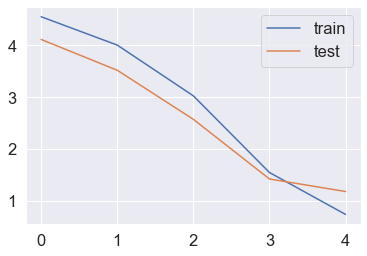

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [70]:
yhat = model.predict(X_testT)

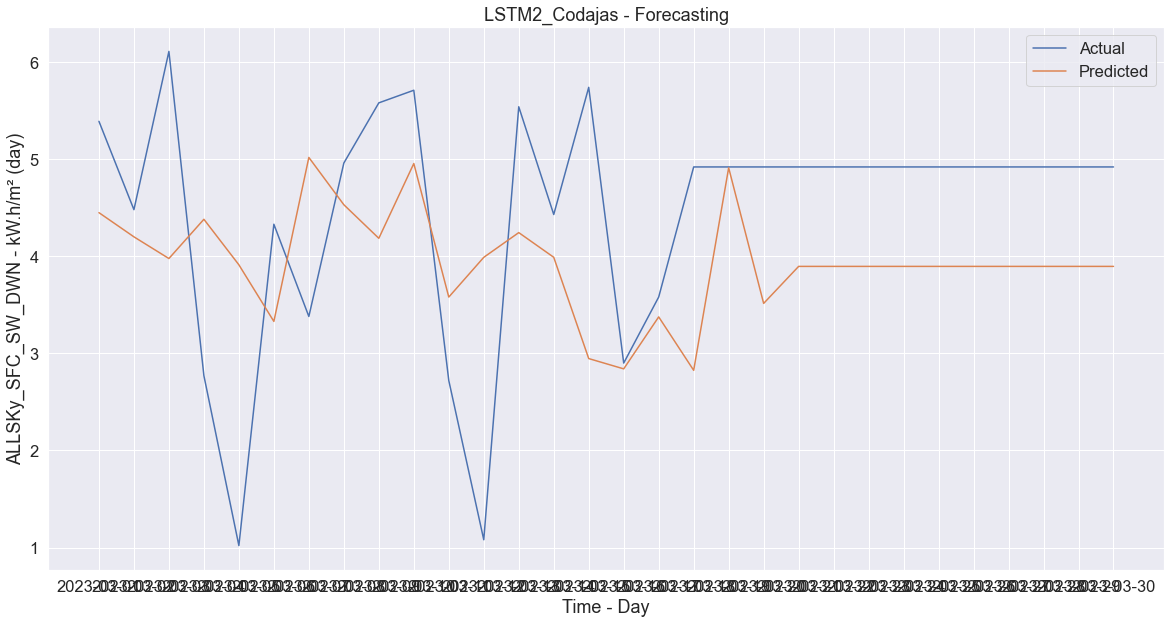

In [71]:
plot_result(y_test,yhat,'LSTM2_Codajas')

In [72]:
w = mape(y_test,yhat)
w 

39.63413838211402

In [73]:
rmse = sqrt(mean_squared_error(y_test,yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.398


In [74]:
end = time.time()

In [75]:
exec_time = end - start

In [76]:
a = y_test
b = yhat
Result = pd.DataFrame()
Result['Case'] = ['Cod_30d']
Result['R2'] = round(r2_score (a,b),3)
Result['MSE'] = round(mean_squared_error(a,b),3)
Result['MAE'] = round(mean_absolute_error(a,b),3)
Result['MAPE'] = round(w,3)
Result['exec_time'] = round(exec_time,3)
Result.head(2)

,Case,R2,MSE,MAE,MAPE,exec_time
0,Cod_30d,-0.282,1.955,1.18,39.634,12.056


In [77]:
Result.to_csv('Cod_LSTM2_30d.csv', sep =',', encoding = 'utf-8')